# inspect llc parcel simulation

In [1]:
import os, shutil
import glob

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import xgcm

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile
#from parcels import FieldSet, ParticleFile, plotTrajectoriesFile
#from mitequinox.particleset import ParticleSet
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=2)
#
from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
#cluster = PBSCluster(processes=5, cores=5, walltime='04:00:00')
#cluster = PBSCluster(walltime='04:00:00')
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.71:46447 Dashboard: http://10.148.1.71:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup directories and run parameters

In [3]:
#root_dir = ut.root_data_dir+'parcels/'
root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/dunree/slgentil/tmp/parcels/'

# 5x20 tiles
#run_name = 'test'
# 10x10 tiles
#run_name = "test1"
# 5x5 tiles
#run_name = 'test2'
#run_name = 'test3'
run_name = 'test4'

run_dir = root_dir+run_name

In [4]:
# not working pickle issue

#tile_dir = os.path.join(run_dir,'tiling/')

#tl = pa.tiler(tile_dir=tile_dir)    
#tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
#                  for t in range(tl.N_tiles)
#                 ]

In [5]:
# simulation parameters

#T = 360? # length of the total run [days]
T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

dij_init = 10 # initial position subsampling compared to llc grid

---

## load llc data

In [6]:
%%time
# load llc data
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])
ds

CPU times: user 2.32 s, sys: 140 ms, total: 2.46 s
Wall time: 27 s


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

---

## create tiles - !!! should be deleted eventually

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [7]:
# simulation parameters
dij_init = 10 # initial position subsampling compared to llc grid

In [8]:
%%time

create_tiles = False

#tile_dir = os.path.join(run_dir,'tiling/')
tile_dir = '/home1/scratch/aponte/parcels/tile_tmp/'
if create_tiles:
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient

    # create tiler
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(10, 10), overlap=(100, 100))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 20), overlap=(100, 100))
    tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(100, 100))
    # store tiler
    tl.store(tile_dir)
    
else:
    
    #tile_dir = ut.root_data_dir+'parcels/tiling/'
    #tile_dir = os.path.join(run_dir,'tiling/')
    tl = pa.tiler(tile_dir=tile_dir)
    
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(tl.N_tiles)
                 ]

CPU times: user 184 ms, sys: 24 ms, total: 208 ms
Wall time: 924 ms


---
## load dataset and plot a subset of trajectories

In [13]:
float_files = []
for _dir in tile_data_dirs:
    float_files.extend(sorted(glob.glob(_dir+"/floats_1*.nc")))
float_files[:10]

['/home1/scratch/aponte/parcels/test4/data_001/floats_100_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_101_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_102_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_103_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_104_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_105_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_106_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_107_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_108_001.nc',
 '/home1/scratch/aponte/parcels/test4/data_001/floats_109_001.nc']

In [16]:
def xr2df(file):
    return xr.open_dataset(file).to_dataframe().reset_index('traj')

lazy_dataframes = [delayed(xr2df)(f) for f in float_files]

In [17]:
_df = lazy_dataframes[0].compute()
_df
_df.iloc[0]['time']

Timestamp('2012-02-23 00:00:00')

In [19]:
#_df[_df['time']<pd.Timestamp(2012, 3, 12+1)]
_df[_df['time']<pd.Timestamp(2012, 2, 25)]

,traj,trajectory,time,lat,lon,z
obs,,,,,,
0,0,1046050.0,2012-02-23,-47.569329,20.538970,0.0
0,1,1069993.0,2012-02-23,-47.066657,29.688295,0.0
0,2,2044077.0,2012-02-23,-47.202491,-2.827745,0.0
0,3,2050760.0,2012-02-23,-47.004868,27.534992,0.0
0,4,2051274.0,2012-02-23,-47.095214,27.586549,0.0
...,...,...,...,...,...,...
24,349,6009227.0,2012-02-24,-69.861676,23.056332,0.0
24,350,6009228.0,2012-02-24,-69.846051,23.343949,0.0
24,351,6009229.0,2012-02-24,-69.738916,21.386627,0.0


In [20]:
df = dd.from_delayed(lazy_dataframes, meta=lazy_dataframes[0].compute())

t0 = pd.Timestamp(2012,2,23)
t1 = pd.Timestamp(2012,3,8)
df = df[ (df['time']>=t0) & (df['time']<=t1)]

In [21]:
#df = df.persist()
df_pd = df.compute() # load in notebook, dangerous !!

### plot one time

In [29]:
_d = df_pd[df_pd['time']==pd.Timestamp(2012,2,23)]
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

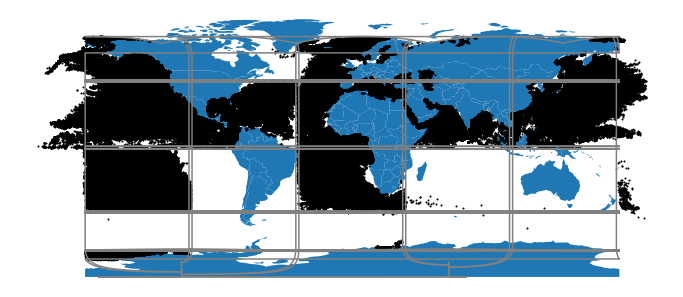

In [36]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='k', markersize=1)
ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Close cluster

In [37]:
cluster.close()